## Pre-processing

In [1]:
import warnings
#warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

from numba import autojit, prange
from datetime import datetime
import pickle
from tqdm import tqdm

import math

tqdm.pandas(desc="progress-bar")

In [2]:
df=pd.read_csv("../data/final_2017_2018_OFF.csv")

In [10]:
df.date.head()

0    2017-01-28 00:00:00
1    2017-01-28 01:00:00
2    2017-01-28 02:00:00
3    2017-01-28 03:00:00
4    2017-01-28 04:00:00
Name: date, dtype: object

In [11]:
df.date=pd.to_datetime(df.date) # re formatting datetime

In [28]:
df.date.head()

0   2017-01-28 00:00:00
1   2017-01-28 01:00:00
2   2017-01-28 02:00:00
3   2017-01-28 03:00:00
4   2017-01-28 04:00:00
Name: date, dtype: datetime64[ns]

In [29]:
df.drop("Unnamed: 0", axis=1, inplace=True)

In [30]:
df.date.unique()

array(['2017-01-28T00:00:00.000000000', '2017-01-28T01:00:00.000000000',
       '2017-01-28T02:00:00.000000000', ...,
       '2018-08-31T21:00:00.000000000', '2018-08-31T22:00:00.000000000',
       '2018-08-31T23:00:00.000000000'], dtype='datetime64[ns]')

In [8]:
# as seen previously we plot one random supply function
random_day = "2017-01-28 02:00:00"

one_bid_df = df[df.date == random_day]

one_bid_df.sort_values(by = "energy_price_no", inplace = True)

one_bid_df["cumsum_qt"] = np.cumsum(one_bid_df["quantity_no"])

one_bid_df.plot(kind = "line", x = "energy_price_no", y = "cumsum_qt", ylim=14000).set_xlim(0,250)

## Price's grid and grid function

The grid is realized using 50-iles of 0-260 interval


grid <- c(0.0000,2.5164,5.0128,7.5092,10.0056,12.5020,14.9984,17.4948,19.9912,
         22.4876,24.984,27.4804,29.976,32.4732,34.969,37.4660,39.962,42.4588,
         44.9552,47.4516,49.9480,52.444,54.9408,57.437,59.9336,62.430,64.9264,
         67.4228,69.919,72.4156,74.912,77.4084,79.904,82.4012,84.897,87.3940,
         89.8904,92.3868,94.8832,97.4396,100.0060,102.8324,105.6688,108.6952,
         111.8316,115.2660,119.3044,124.6716,129.5072,138.3468,259.0300)

   
sgrid <- function(dt, grid) {

        PQ <- dt %>%
        group_by(ENERGY_PRICE_NO) %>%
        summarise(quantity = sum(QUANTITY_NO)) %>%
        mutate(quantity = cumsum(quantity)) %>%
        rename(price = ENERGY_PRICE_NO)
        out <- sapply(grid, function(x) {y <- PQ$quantity[PQ$price <= x]; y[length(y)]})
        names(out) <- grid
        out
    }

In [13]:
# We try to apply groupby on prices in order to take only singular values

gb_df = df[df.date == random_day]

y = gb_df.groupby("energy_price_no").sum().quantity_no.cumsum()

y.reset_index().head()

x=np.sort(gb_df.energy_price_no.unique())

## Differences between supply function groupby price vs not groupby price

(14000, 24707.26555)

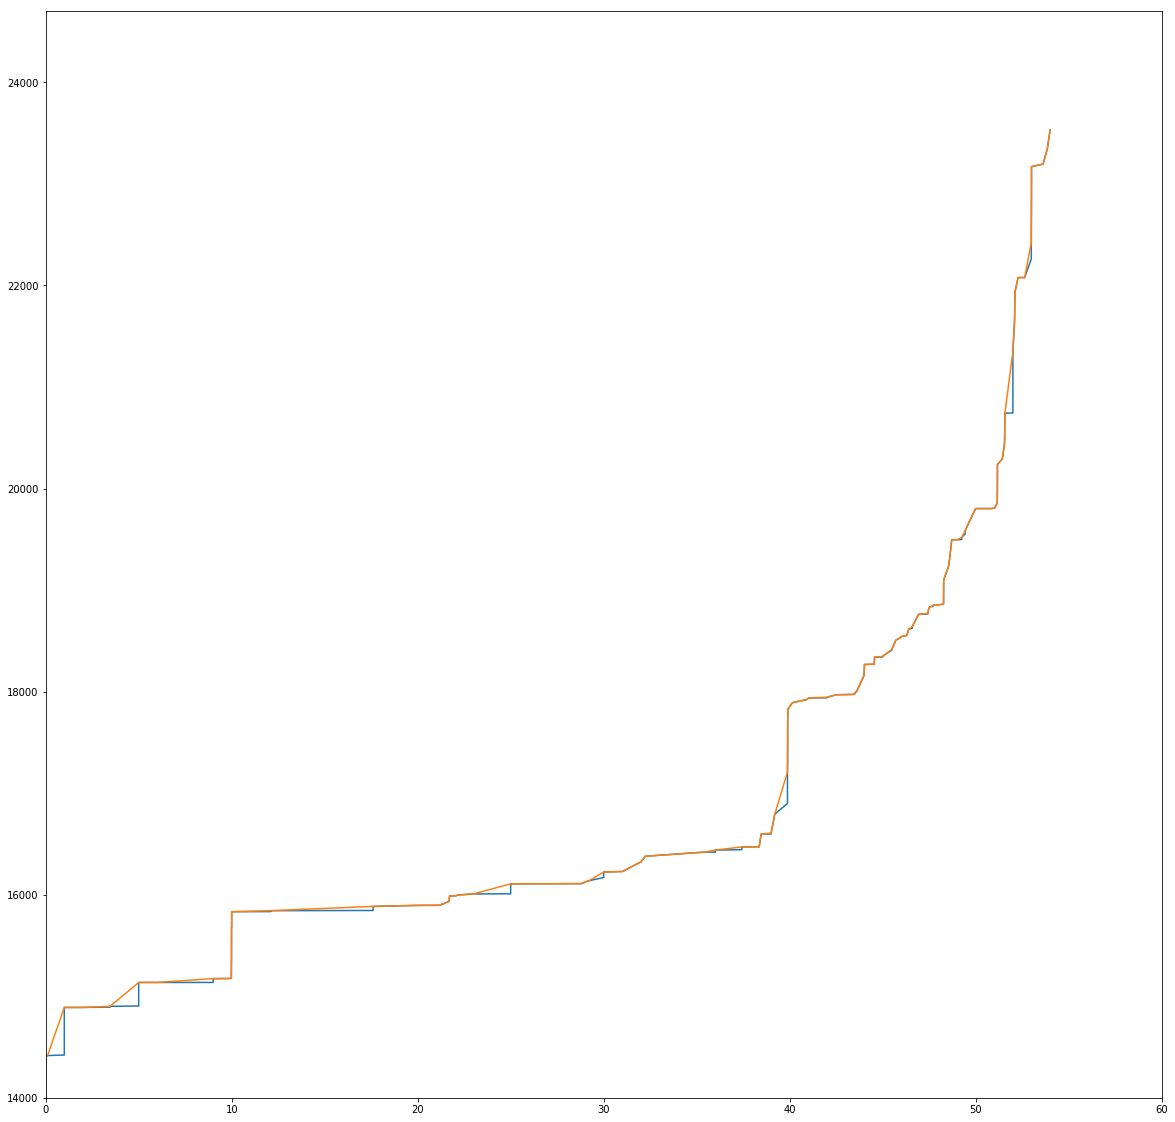

In [17]:
fig, ax = plt.subplots(figsize=(20, 20))

plt.plot(one_bid_df.energy_price_no, one_bid_df.cumsum_qt)
#one_bid_df.plot(kind="line", x="energy_price_no", y="cumsum_qt", ylim=14000).set_xlim(0,60)
plt.plot(x,y)
plt.xlim(0,60)
plt.ylim(14000,)

In [13]:
grid = [ 0.0000,2.5164,5.0128,7.5092,10.0056,12.5020,14.9984,17.4948,19.9912,
         22.4876,24.984,27.4804,29.976,32.4732,34.969,37.4660,39.962,42.4588,
         44.9552,47.4516,49.9480,52.444,54.9408,57.437,59.9336,62.430,64.9264,
         67.4228,69.919,72.4156,74.912,77.4084,79.904,82.4012,84.897,87.3940,
         89.8904,92.3868,94.8832,97.4396,100.0060,102.8324,105.6688,108.6952,
         111.8316,115.2660,119.3044,124.6716,129.5072,138.3468,259.0300]


#sgrid = [one_bid_df[one_bid_df.energy_price_no <= pt].tail(1).reset_index().cumsum_qt[0] for pt in grid]

In [12]:
def make_sgrid(dt, date, grid = grid):
    """    
        dt: pd.dataframe
        date: datetime.datetime
        grid: list
        
        Sample the supply function from a given grid of prices
    """
    
    one_bid_df=dt[dt.date==date]
    one_bid_df.sort_values(by="energy_price_no", inplace=True)
    one_bid_df["cumsum_qt"]=np.cumsum(one_bid_df["quantity_no"])
    
    sgrid=[one_bid_df[one_bid_df.energy_price_no <= pt].tail(1).reset_index().cumsum_qt[0] for pt in grid]
    return sgrid

def make_sgrid_groupby(dt, date, grid = grid):
    """    
        dt: pd.dataframe
        date: datetime.datetime
        grid: list
        
        Sample the supply function from a given grid of prices after using groupby on that prices
    """
    one_bid_df=dt[dt.date==date]
    one_bid_df=one_bid_df.groupby("energy_price_no").sum().quantity_no.cumsum().reset_index()
    
    sgrid=[one_bid_df[one_bid_df.energy_price_no <= pt].tail(1).reset_index().quantity_no[0] for pt in grid]
    return sgrid 
    

In [22]:
%%timeit 
sgrid=make_sgrid(df,random_day)

/home/dario/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/dario/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


144 ms ± 607 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
%%timeit 
gb_sgrid=make_sgrid_groupby(df, random_day) #better the Shearcat version

65.4 ms ± 2.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Version that apply groupby before sampling prices is faster

In [24]:
gb_sgrid=make_sgrid_groupby(df, random_day) # better the Shearcat version

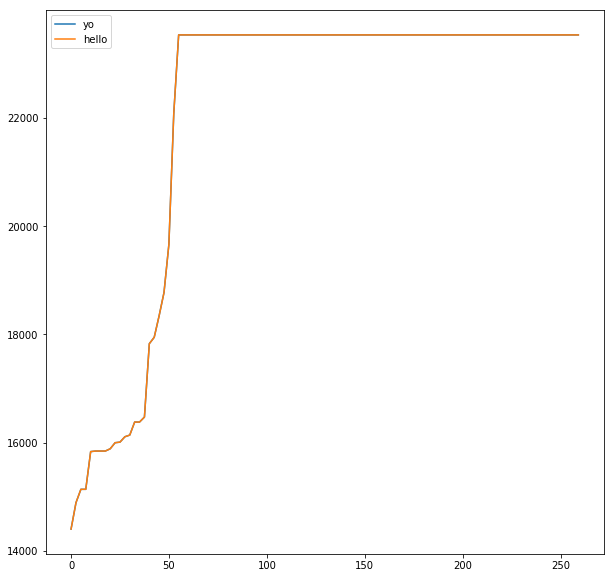

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))

plt.plot(grid, sgrid,  label="yo")
plt.plot(grid, gb_sgrid, label="hello")
plt.legend()

In [28]:
print("There are ", len(df.date.unique()), " rows")

7152

In [ ]:
# preparing our axes for 3D plot

fig, ax = plt.subplots(figsize=(20, 20))

plt.xlabel("Price")
plt.ylabel("Quantity(cumsum)")

X=[]
Y=[]
Z=[]
n=30
stop=240
count=0

for date in np.sort(df.date.unique()):
    
    sgrid=make_sgrid_groupby(df,date)
    X.append(pd.Series(grid[:n]))
    Y.append(pd.Series(sgrid[:n]))
    
    plt.plot(grid[:n], sgrid[:n], label=date)
    Z.append(pd.Series([pd.Timestamp(date).to_pydatetime().timestamp() for elem in range(len(grid[:n]))]))
    
    count+=1
    if count ==stop:
        break


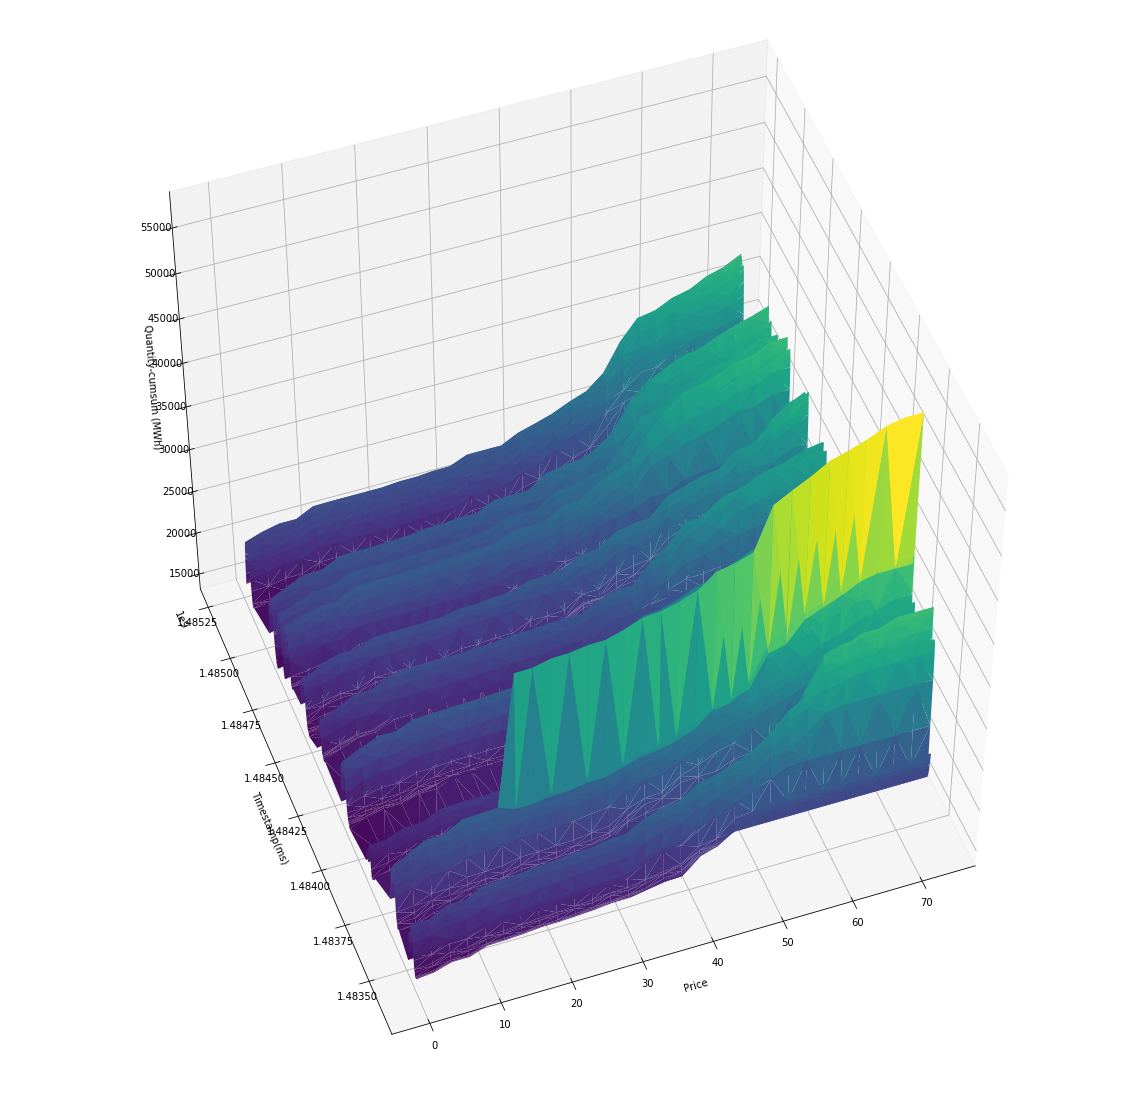

In [30]:
# plot

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')

Xp=pd.concat(X)
Yp=pd.concat(Y)
Zp=pd.concat(Z)

ax.view_init(50,250)

ax.set_xlabel('Price')
ax.set_ylabel('Timestamp(ms)')
ax.set_zlabel('Quantity-cumsum (MWh)')

ax.plot_trisurf(Xp, Zp, Yp, linewidth=0.1, antialiased=True, cmap="viridis")#plt.cm.CMRmap)

## Creating the supply functions S(p)

In [14]:
%time

S1=[]

for date in tqdm(np.sort(df.date.unique())):
    S1.append(make_sgrid_groupby(df,date))

  0%|          | 0/7152 [00:00<?, ?it/s]

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


100%|██████████| 7152/7152 [08:15<00:00, 15.28it/s]


In [20]:
# Save our Supply list object

#with open('SupplyList.pickle', 'wb') as fp:
#    pickle.dump(S1, fp)

In [3]:
Open = False
if Open:
    file = open("dumps/SupplyList.pickle", "rb")
    S1 = pickle.load(file)
    file.close()

In [4]:
print("There are {} columns (dates) and {} rows (prices)".format(len(S1), len(S1[0]))) # check

(7152, 51)

In [5]:
# Time to create our S(p)

Sp = [[elem[i] for elem in S1] for i in range(len(S1[0]))] # arrange data

In [6]:
print("There are {} columns (prices) and {} rows (dates)".format(len(Sp), len(Sp[0]))

7152

In [18]:
# Save our time series object

#with open('TimeSeries.pickle', 'wb') as fp:
#    pickle.dump(Sp, fp)

In [13]:
Open = False
if Open:
    with open("TimeSeries.pickle", "rb") as file:
        Sp = pickle.load(file)

In [3]:
print("There are {} columns (prices) and {} rows (dates)".format(len(Sp), len(Sp[0]))

(51, 7152)

In [15]:
# Save our dates object

dates = np.sort(df.date.unique())

dump = False
if dump:
    with open("dates.pickle", "wb") as outfile:
        pickle.dump(dates, outfile)

In [16]:
Open = False
if Open:
    with open("dumps/dates.pickle", "rb") as infile:
        dates=pickle.load(infile)

<hr>

## Visualizing

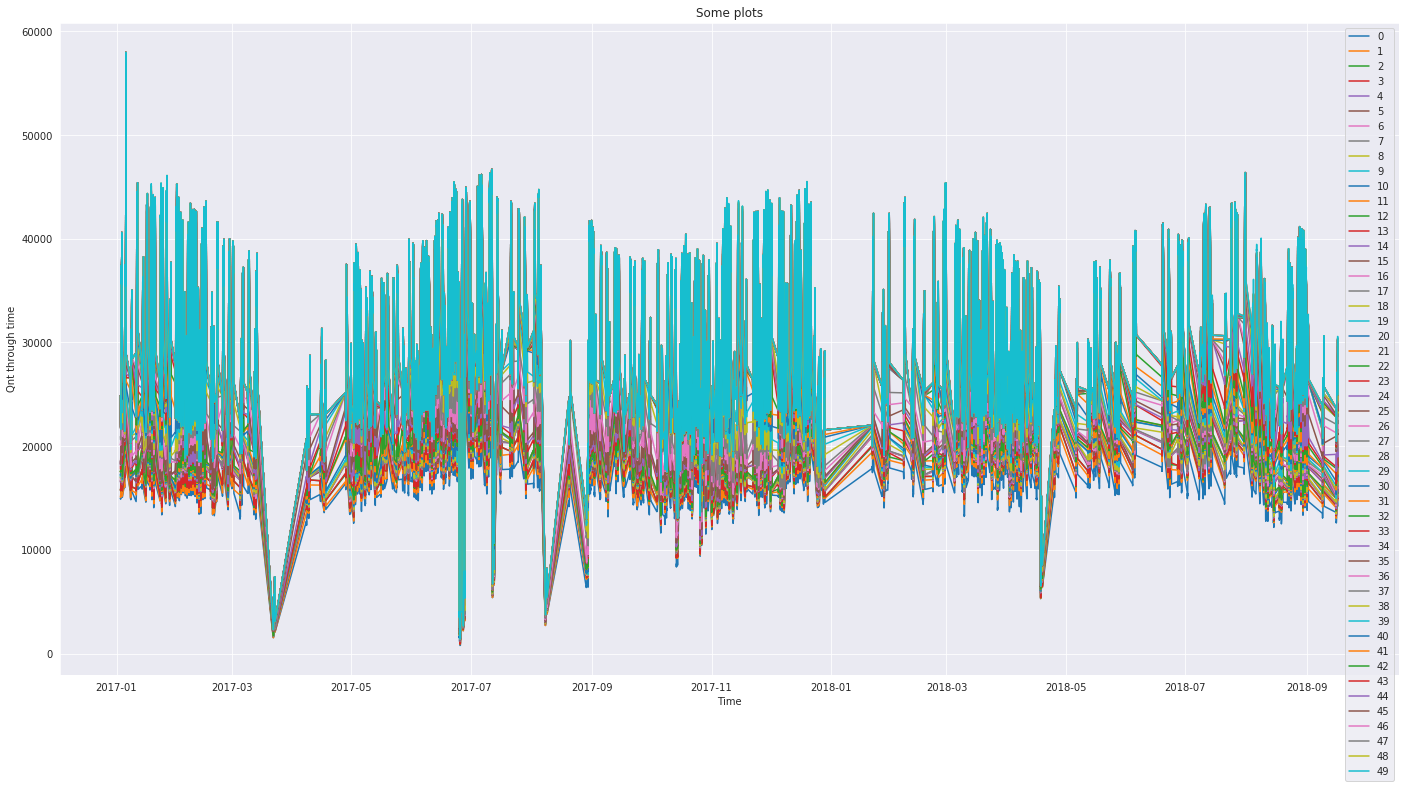

In [53]:
# plotting first 50 time series

sns.set_style("darkgrid")
plt.figure(figsize = (24,12))

for elem in range(0, 50):
    sns.lineplot(x = np.sort(df.date.unique()), y = Sp[elem], label=elem)#, color = "#917ca6")

    
plt.xlabel("Time")
plt.ylabel("Qnt through time")
plt.title("Some plots")
plt.legend()

We need to understand why there are these negative peaks

In [31]:
ts = pd.Series(Sp[0]) # All the dates under P0

In [ ]:
dates[ts.idxmin()] # select the minimum value

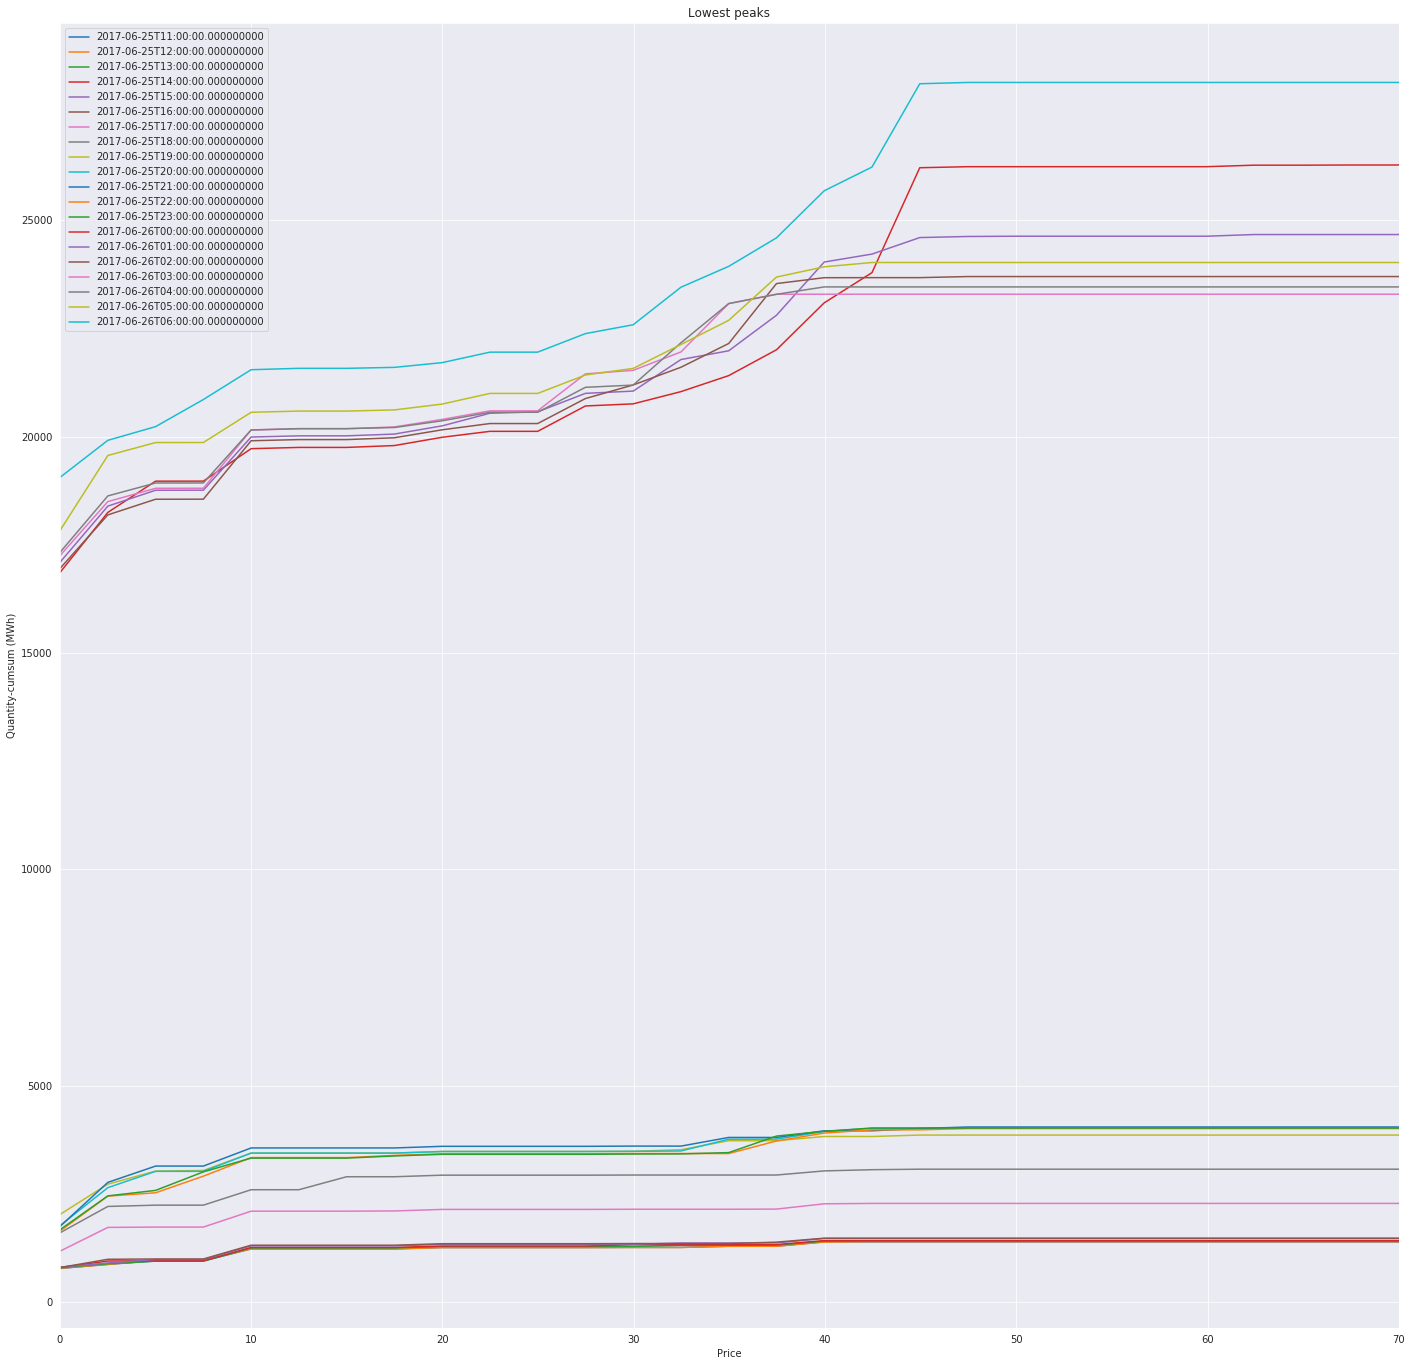

In [52]:
sns.set_style("darkgrid")
plt.figure(figsize = (24,24))

# plot 20 hours after the minimum peak identified previously
for i in range(20):
    sns.lineplot(x = grid, y = S1[ts.idxmin()+i], label=dates[ts.idxmin()+i])#, color = "#917ca6")
    
plt.xlim(0,70)
plt.xlabel("Price")
plt.ylabel("Quantity-cumsum (MWh)")
plt.title("Lowest peaks")
plt.legend()
    

## Make log transformation as in eq pag 207 sec 4

In [4]:
def make_q(S, c=1):
    q=[]
    q.append(math.log(S[0]))
    for i in range(1,len(S)):
        q.append(math.log(S[i]-S[i-1]+c))
    return q

In [31]:
q_try = make_q(S1[-3])

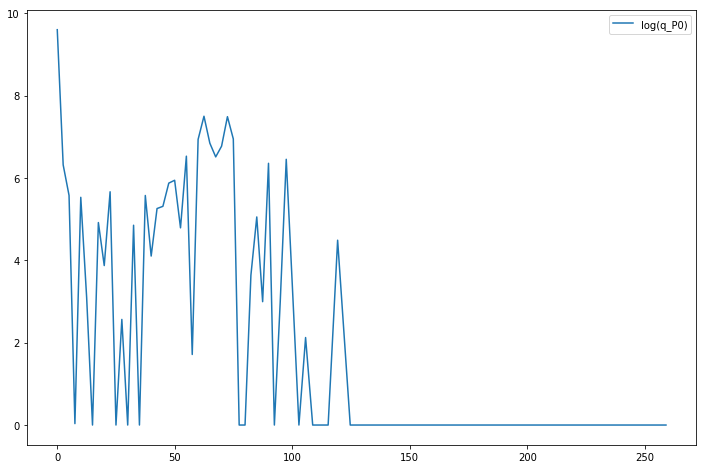

In [32]:
# compare the two supply functions

plt.figure(figsize = (12,8))

plt.plot(grid, q_try, label = "log(q_P0)")
#plt.plot(grid, S1[0], label = "q_P0")

plt.legend()

In [6]:
# log transformation
q_t_list = [make_q(sup) for sup in S1]

In [7]:
print("Dimensions: ({}, {})".format(len(q_t_list), len(q_t_list[9])))

Dimensions: (7152, 51)


In [8]:
# re arrange our data in time series format

q_p_list=[[elem[i] for elem in q_t_list] for i in range(len(q_t_list[0]))]

In [9]:
print("Dimesions: ({}, {})".format(len(q_p_list),len(q_p_list[9])))

Dimesions: (51, 7152)


In [10]:
dump=True

if dump:
    with open("q_t_list.pickle", "wb") as outfile:
        pickle.dump(q_t_list, outfile)

    with open("q_p_list.pickle", "wb") as outfile:
        pickle.dump(q_p_list, outfile)


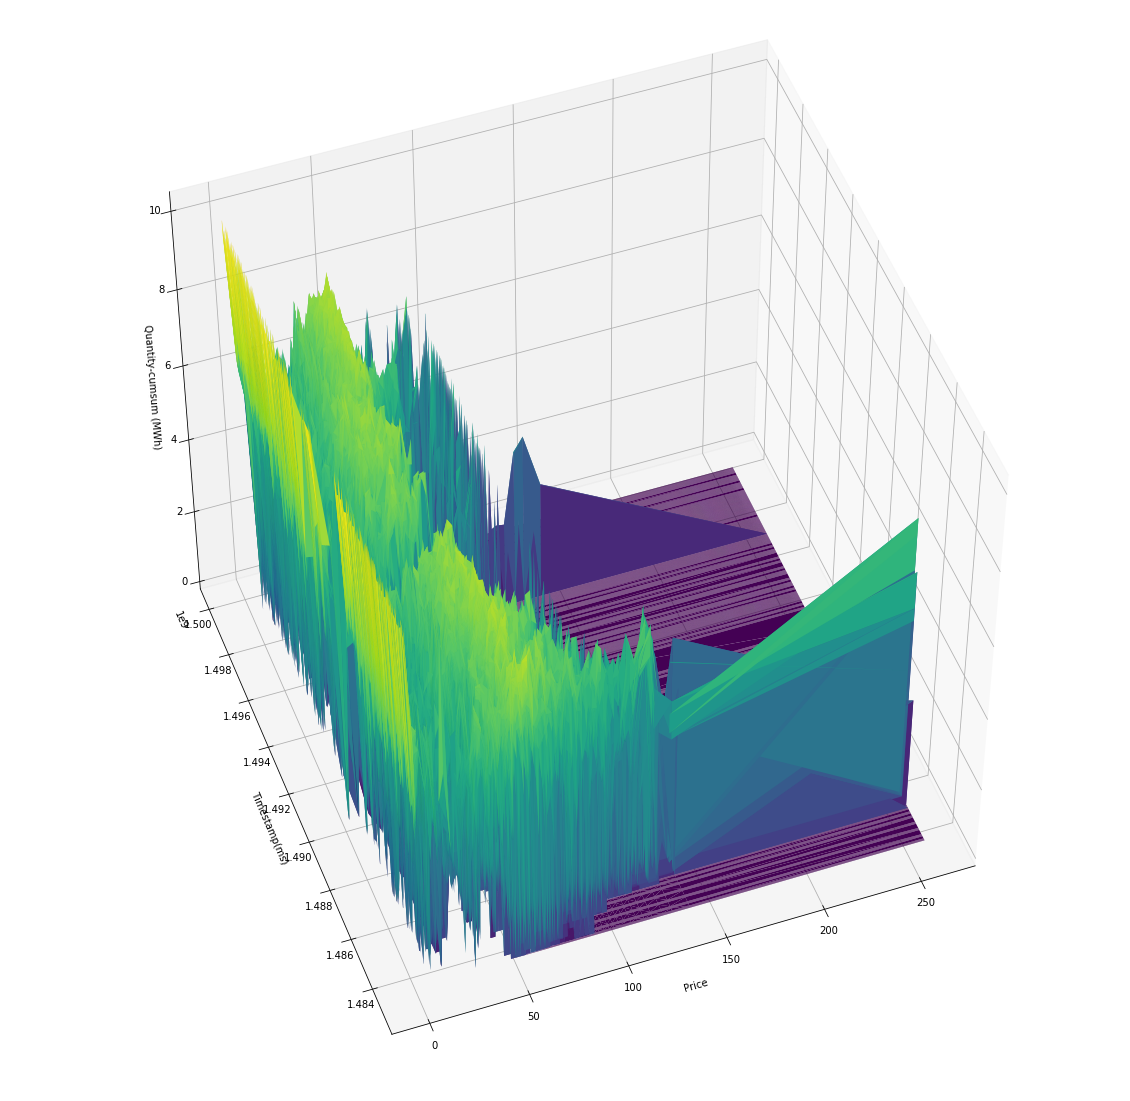

In [18]:
X=[]
Y=[]
Z=[]

n=150
stop=2400
count=0

# plotting 40 hours
for i in range(len(q_t_list)):
    
    X.append(pd.Series(grid[:n]))
    Y.append(pd.Series(q_t_list[i][:n]))
    Z.append(pd.Series([pd.Timestamp(dates[i]).to_pydatetime().timestamp() for elem in range(len(grid[:n]))]))
    
    count+=1
    if count ==stop:
        break


fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')

Xp=pd.concat(X)
Yp=pd.concat(Y)
Zp=pd.concat(Z)

ax.view_init(50,250)

ax.set_xlabel('Price')
ax.set_ylabel('Timestamp(ms)')
ax.set_zlabel('Quantity-cumsum (MWh)')

ax.plot_trisurf(Xp, Zp, Yp, linewidth=0.1, antialiased=True, cmap="viridis")#plt.cm.CMRmap)

In [25]:
df_q_p_list=pd.concat([pd.Series(elem) for elem in q_p_list], axis=1)

df_q_p_list.head()
dump=False
if dump:
    df_q_p_list.to_csv("dumps/q_p_list.csv", index=False)

<hr>

In [45]:
%whos

Variable   Type              Data/Info
--------------------------------------
Axes3D     type              <class 'mpl_toolkits.mplot3d.axes3d.Axes3D'>
S1         list              n=7152
Sp         list              n=51
datetime   type              <class 'datetime.datetime'>
df         DataFrame                 purpose_cd  quant<...>445607 rows x 10 columns]
elem       int               2
file       BufferedReader    <_io.BufferedReader name='TimeSeries.pckle'>
fp         BufferedWriter    <_io.BufferedWriter name='TimeSeries.pckle'>
np         module            <module 'numpy' from '/ho<...>kages/numpy/__init__.py'>
pd         module            <module 'pandas' from '/h<...>ages/pandas/__init__.py'>
pickle     module            <module 'pickle' from '/u<...>lib/python3.7/pickle.py'>
plt        module            <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>
sns        module            <module 'seaborn' from '/<...>ges/seaborn/__init__.py'>
tqdm       type              <cl